<a href="https://colab.research.google.com/github/victory2588/Machine-Learning/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EC%BB%A8%EB%B3%BC%EB%A3%A8%EC%85%98_%EC%8B%A0%EA%B2%BD%EB%A7%9D%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EC%98%81%EC%83%81_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

(ds_train,ds_test,ds_validation), ds_info = tfds.load(
    'colorectal_histology',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],  # 훈련셋, 테스트셋, 검증셋
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/colorectal_histology/2.0.0.incompleteJBWCNI/colorectal_histology-train.tfrecor…

Dataset colorectal_histology downloaded and prepared to ~/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [2]:
CLASS_NUM = ds_info.features['label'].num_classes # = 8
CLASS_NAMES = ["tumor",
    "stroma",
    "complex",
    "lympho",
    "debris",
    "mucosa",
    "adipose",
    "empty",]

print(f'num of class: {CLASS_NUM}\n')

for i in range(CLASS_NUM):
    print(i, CLASS_NAMES[i])

num of class: 8

0 tumor
1 stroma
2 complex
3 lympho
4 debris
5 mucosa
6 adipose
7 empty


In [3]:
BATCH_SIZE = 64
BUFFER_SIZE = 5000

def preprocess_data(image, label) :
    image = tf.cast(image, tf.float32) / 255.
    return image, label

train_data = ds_train.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
test_data = ds_test.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = ds_validation.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [4]:
def data_augmentation(image, label):
    image=tf.image.random_flip_left_right(image)
    image=tf.image.random_flip_up_down(image)
    image=tf.image.random_brightness(image, max_delta=0.3)
    # 이미지 색상 float로
    image = tf.cast(image, tf.float32)/255

    return image, label

train_aug = ds_train.map(data_augmentation,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_aug = ds_test.map(data_augmentation,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_aug = test_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_aug = ds_validation.map(data_augmentation,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_aug = val_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

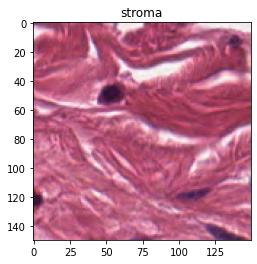

In [5]:
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(ds_info.features["label"].int2str(label));

In [6]:
def plot_loss_acc(history, epoch) :
    
    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')
    
    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()
    

CNN(1) - CCPCCP

In [9]:
model = Sequential()
model.add(keras.layers.Conv2D(32, (3,3), padding='same', activation='relu',
                              input_shape=(150, 150, 3)))
model.add(keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(CLASS_NUM, activation='softmax'))

keras.utils.plot_model(model, show_shapes=True, dpi = 70)

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(ds_train,batch_size=BATCH_SIZE, epochs=40,validation_data=ds_validation)

# 정확도
test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print(f'\n테스트 정확도: {test_acc*100:.2f}%')

plot_loss_acc(history, 40)


Epoch 1/40


ValueError: ignored

CNN(2) - CPCPCPCP

In [10]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu',
                              input_shape=(150, 150, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(CLASS_NUM, activation='softmax'))

keras.utils.plot_model(model, show_shapes=True, dpi = 70)

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(ds_train,batch_size=BATCH_SIZE, epochs=40,validation_data=ds_validation,verbose=2)

# 정확도
plot_loss_acc(history, 40)

Epoch 1/40


ValueError: ignored

CNN(2) - dropout 없음

In [11]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu',
                              input_shape=(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.0))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.0))
model.add(keras.layers.Dense(CLASS_NUM, activation='softmax'))

keras.utils.plot_model(model, show_shapes=True, dpi = 70)

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(ds_train,batch_size=BATCH_SIZE, epochs=EPOCHS,validation_data=ds_validation)

# 정확도
test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print(f'\n테스트 정확도: {test_acc*100:.2f}%')

plot_loss_acc(history, 40)

NameError: ignored

CNN(2) - 훈련셋, 테스트셋, 검증셋 비율 조정

Epoch 1/40
63/63 [==============================] - 16s 61ms/step - loss: 1.6122 - accuracy: 0.3058 - val_loss: 1.4728 - val_accuracy: 0.3880
Epoch 2/40
63/63 [==============================] - 6s 43ms/step - loss: 1.1204 - accuracy: 0.5042 - val_loss: 0.9664 - val_accuracy: 0.5280
Epoch 3/40
63/63 [==============================] - 6s 43ms/step - loss: 0.9480 - accuracy: 0.5947 - val_loss: 0.7547 - val_accuracy: 0.6980
Epoch 4/40
63/63 [==============================] - 6s 43ms/step - loss: 0.8594 - accuracy: 0.6350 - val_loss: 0.7662 - val_accuracy: 0.7060
Epoch 5/40
63/63 [==============================] - 6s 43ms/step - loss: 0.7669 - accuracy: 0.6963 - val_loss: 0.6832 - val_accuracy: 0.7200
Epoch 6/40
63/63 [==============================] - 6s 43ms/step - loss: 0.7190 - accuracy: 0.7170 - val_loss: 0.8294 - val_accuracy: 0.6240
Epoch 7/40
63/63 [==============================] - 6s 43ms/step - loss: 0.6990 - accuracy: 0.7132 - val_loss: 0.8529 - val_accuracy: 0.6920
Epoch 8/40
6

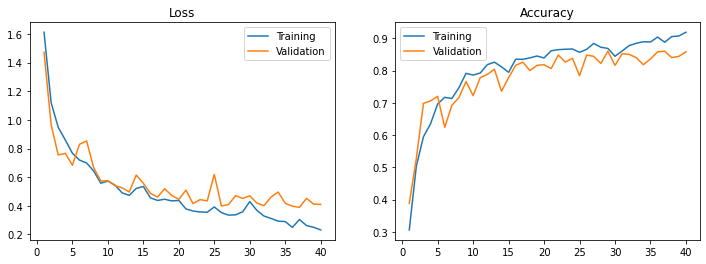

In [12]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu',
                              input_shape=(150, 150, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(CLASS_NUM, activation='softmax'))

keras.utils.plot_model(model, show_shapes=True, dpi = 70)

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train_data,batch_size=BATCH_SIZE, epochs=40,validation_data=valid_data)

# 정확도
plot_loss_acc(history, 40)

CNN(2) - 데이터 증대

Epoch 1/40
63/63 - 8s - loss: 1.6004 - accuracy: 0.3072 - val_loss: 1.3093 - val_accuracy: 0.4040 - 8s/epoch - 120ms/step
Epoch 2/40
63/63 - 7s - loss: 1.2178 - accuracy: 0.4735 - val_loss: 1.2181 - val_accuracy: 0.4540 - 7s/epoch - 108ms/step
Epoch 3/40
63/63 - 7s - loss: 1.0961 - accuracy: 0.5397 - val_loss: 0.9470 - val_accuracy: 0.6300 - 7s/epoch - 108ms/step
Epoch 4/40
63/63 - 7s - loss: 1.0007 - accuracy: 0.5807 - val_loss: 0.9572 - val_accuracy: 0.5780 - 7s/epoch - 108ms/step
Epoch 5/40
63/63 - 7s - loss: 0.9167 - accuracy: 0.6235 - val_loss: 0.7221 - val_accuracy: 0.7340 - 7s/epoch - 108ms/step
Epoch 6/40
63/63 - 7s - loss: 0.7793 - accuracy: 0.6913 - val_loss: 0.6674 - val_accuracy: 0.7220 - 7s/epoch - 107ms/step
Epoch 7/40
63/63 - 7s - loss: 0.7655 - accuracy: 0.6977 - val_loss: 0.6932 - val_accuracy: 0.7440 - 7s/epoch - 108ms/step
Epoch 8/40
63/63 - 7s - loss: 0.7176 - accuracy: 0.7193 - val_loss: 0.6563 - val_accuracy: 0.7240 - 7s/epoch - 108ms/step
Epoch 9/40
63/63 - 7s - 

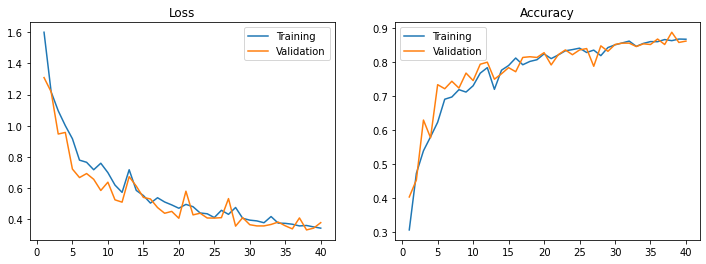

In [13]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu',
                              input_shape=(150, 150, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(CLASS_NUM, activation='softmax'))

keras.utils.plot_model(model, show_shapes=True, dpi = 70)

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_aug,batch_size=BATCH_SIZE, epochs=40,validation_data=val_aug,verbose=2)

# 정확도
plot_loss_acc(history, 40)

CNN(2) - 데이터 증대(dropout x)

Epoch 1/40
63/63 - 8s - loss: 1.4959 - accuracy: 0.3725 - val_loss: 1.4209 - val_accuracy: 0.3460 - 8s/epoch - 120ms/step
Epoch 2/40
63/63 - 7s - loss: 1.1778 - accuracy: 0.4897 - val_loss: 1.1087 - val_accuracy: 0.4960 - 7s/epoch - 109ms/step
Epoch 3/40
63/63 - 7s - loss: 1.0386 - accuracy: 0.5727 - val_loss: 1.2069 - val_accuracy: 0.5000 - 7s/epoch - 109ms/step
Epoch 4/40
63/63 - 7s - loss: 0.9668 - accuracy: 0.6140 - val_loss: 0.8127 - val_accuracy: 0.7120 - 7s/epoch - 108ms/step
Epoch 5/40
63/63 - 7s - loss: 0.7728 - accuracy: 0.6917 - val_loss: 0.7790 - val_accuracy: 0.6760 - 7s/epoch - 109ms/step
Epoch 6/40
63/63 - 7s - loss: 0.7217 - accuracy: 0.7188 - val_loss: 0.6722 - val_accuracy: 0.7480 - 7s/epoch - 109ms/step
Epoch 7/40
63/63 - 7s - loss: 0.7222 - accuracy: 0.7188 - val_loss: 0.7669 - val_accuracy: 0.6940 - 7s/epoch - 109ms/step
Epoch 8/40
63/63 - 7s - loss: 0.7260 - accuracy: 0.7100 - val_loss: 0.8753 - val_accuracy: 0.6360 - 7s/epoch - 108ms/step
Epoch 9/40
63/63 - 7s - 

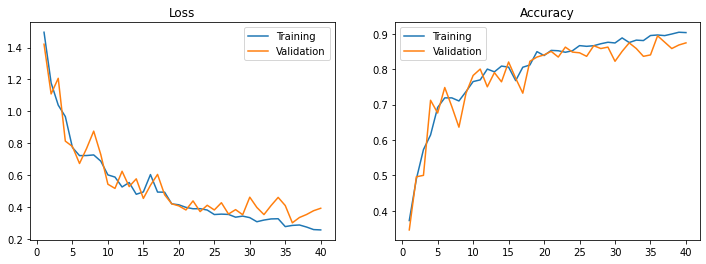

In [14]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu',
                              input_shape=(150, 150, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.0))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.0))
model.add(keras.layers.Dense(CLASS_NUM, activation='softmax'))

keras.utils.plot_model(model, show_shapes=True, dpi = 70)

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_aug,batch_size=BATCH_SIZE, epochs=40,validation_data=val_aug,verbose=2)

# 정확도
plot_loss_acc(history, 40)

Resnet 사전 학습 모델

In [15]:
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False, weights='imagenet', input_shape=[150,150,3])
pre_trained_base.trainable = False

from tensorflow.python.keras.utils.vis_utils import plot_model
#plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')

94668760/94668760 [==============================] - 4s 0us/step


In [ ]:
#Top 층에 Classifier 추가
def build_trainsfer_classifier():
   model = tf.keras.Sequential([
       pre_trained_base,
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(512, activation='relu'),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(CLASS_NUM, activation='softmax'),
    ])
   return model

tc_model = build_trainsfer_classifier()
tc_model.summary()

tc_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

tc_history = tc_model.fit(train_aug,batch_size=BATCH_SIZE, epochs=40,validation_data=val_aug,verbose=2)
plot_loss_acc(tc_history, 40)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 flatten_6 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_14 (Dropout)        (None, 51200)             0         
                                                                 
 dense_12 (Dense)            (None, 512)               26214912  
                                                                 
 dropout_15 (Dropout)        (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 8)                 4104      
                                                                 
Total params: 49,783,816
Trainable params: 26,219,016


In [ ]:
tc_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

tc_history = tc_model.fit(train_aug,batch_size=BATCH_SIZE, epochs=40,validation_data=val_aug,verbose=2)
plot_loss_acc(tc_history, 40)

Epoch 1/40
63/63 - 26s - loss: 1.8012 - accuracy: 0.6948 - val_loss: 0.4482 - val_accuracy: 0.8480 - 26s/epoch - 415ms/step
Epoch 2/40
63/63 - 11s - loss: 0.6658 - accuracy: 0.7995 - val_loss: 0.4509 - val_accuracy: 0.8320 - 11s/epoch - 170ms/step
Epoch 3/40
63/63 - 11s - loss: 0.5936 - accuracy: 0.8140 - val_loss: 0.4740 - val_accuracy: 0.8320 - 11s/epoch - 173ms/step
Epoch 4/40
63/63 - 11s - loss: 0.5522 - accuracy: 0.8290 - val_loss: 0.4194 - val_accuracy: 0.8520 - 11s/epoch - 173ms/step
Epoch 5/40
63/63 - 11s - loss: 0.4789 - accuracy: 0.8360 - val_loss: 0.3600 - val_accuracy: 0.8680 - 11s/epoch - 172ms/step
Epoch 6/40
63/63 - 11s - loss: 0.4641 - accuracy: 0.8512 - val_loss: 0.3989 - val_accuracy: 0.8780 - 11s/epoch - 172ms/step
Epoch 7/40
63/63 - 11s - loss: 0.4751 - accuracy: 0.8455 - val_loss: 0.3438 - val_accuracy: 0.8820 - 11s/epoch - 173ms/step
Epoch 8/40
63/63 - 11s - loss: 0.4152 - accuracy: 0.8620 - val_loss: 0.3415 - val_accuracy: 0.8880 - 11s/epoch - 172ms/step
Epoch 9/

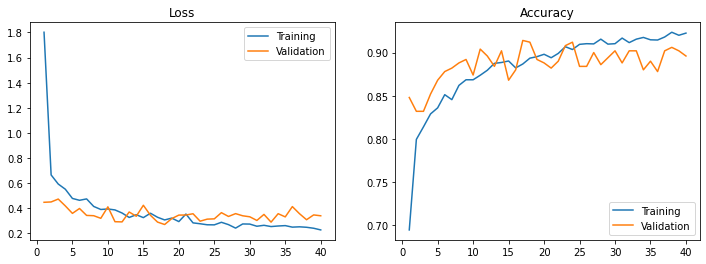

In [ ]:
plot_loss_acc(tc_history, 40)

In [ ]:
from tensorflow.keras.applications import VGG19

pre_trained_base = ResNet50V2(include_top=False, weights='imagenet', input_shape=[150,150,3])
pre_trained_base.trainable = False

from tensorflow.python.keras.utils.vis_utils import plot_model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_2 (Dropout)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               26214912  
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 49,783,816
Trainable params: 26,219,016


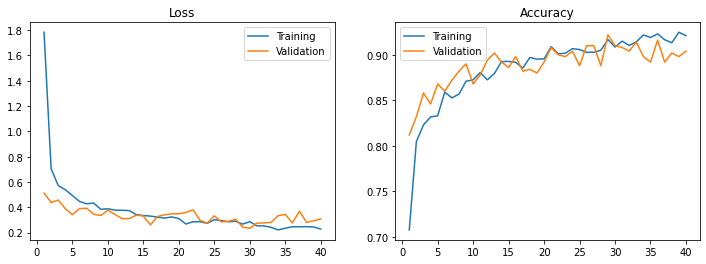

In [ ]:
#Top 층에 Classifier 추가
def build_trainsfer_classifier():

    
   model = tf.keras.Sequential([
       pre_trained_base,
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(512, activation='relu'),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(CLASS_NUM, activation='softmax'),
    ])
   return model

vgg_model = build_trainsfer_classifier()
vgg_model.summary()

vgg_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

vgg_history = vgg_model.fit(train_aug,batch_size=BATCH_SIZE, epochs=40,validation_data=val_aug,verbose=2)
plot_loss_acc(vgg_history, 40)

In [ ]:
from tensorflow.keras.applications import NASNetLarge

pre_trained_base = ResNet50V2(include_top=False, weights='imagenet', input_shape=[150,150,3])
pre_trained_base.trainable = False

from tensorflow.python.keras.utils.vis_utils import plot_model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_4 (Dropout)         (None, 51200)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               26214912  
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 49,783,816
Trainable params: 26,219,016


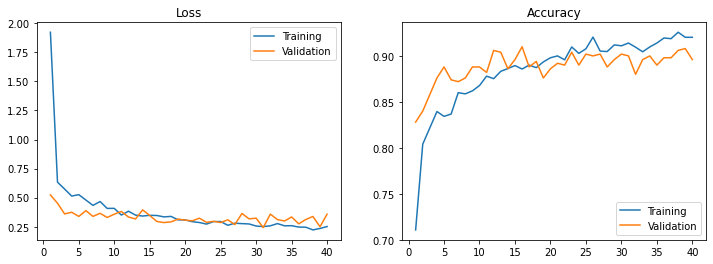

In [ ]:
#Top 층에 Classifier 추가
def build_trainsfer_classifier():

    
   model = tf.keras.Sequential([
       pre_trained_base,
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(512, activation='relu'),
       tf.keras.layers.Dropout(0.5),
       tf.keras.layers.Dense(CLASS_NUM, activation='softmax'),
    ])
   return model

vgg_model = build_trainsfer_classifier()
vgg_model.summary()

vgg_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

vgg_history = vgg_model.fit(train_aug,batch_size=BATCH_SIZE, epochs=40,validation_data=val_aug,verbose=2)
plot_loss_acc(vgg_history, 40)